# Data Preprocessing

- Build a data processing pipeline that takes the raw data and transforms them into a NN trainable dataset


## Imports

In [50]:
# Data
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler

# Other
import time

In [2]:
# Load the datasets
path = "../master-thesis/data/uke_clean.parquet"
uke_df = pd.read_parquet(path)
uke_df.head()

,pat_id,rel_time,af_vital,alt_labor,ast_labor,albumin_labor,alk_labor,alpha_blocker_med,barbiturat_med,basophile_labor,...,ph_bga,pankreasspez_labor,so2_bga,syst_nbd_vital,syst_vital,age,sex,height,weight,length_of_stay
0,474096103,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,130.0,21.0,1,NaN,NaN,8.422222
1,474096103,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,134.0,21.0,1,NaN,NaN,8.422222
2,474096103,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,133.0,21.0,1,NaN,NaN,8.422222
3,474096103,180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,128.0,21.0,1,NaN,NaN,8.422222
4,474096103,240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,125.0,21.0,1,NaN,NaN,8.422222


# Preprocessing

### TODO:

- soemthing is off here, pat_id and rel_time are not used in the fit, so they shoudlnt be part of the transform input either.

In [142]:
class PreprocessingPipeline():
    '''
    -> Outlier handling
    -> Missing-value handling
    '''
    
    def __init__ (self, fill_type, clip_quantile_value) -> None:
        self.fill_type = fill_type # nan, locf, nocb, ema
        self.clip_quantile_value = clip_quantile_value
        
        # will be set up later on
        self.upper_quantiles_clip = None
        self.lower_quantiles_clip = None
        self.mean = None
        self.median = None
        self.std  = None
        self.powerTransformer = None
        self.metadata = None
        
    def fit(self, df: pd.DataFrame) -> None:
        '''
        Calculate quantiles, mean, meadian and std of the dataframe for the transformation steps
        
            Parameters:
            -----------
                df (pd.DataFrame): the input dataframe we are going to gather our values from.
        '''
        
        # remove some columns and set feature columns
        candidates = ['pat_id', 'rel_time']
        df = df.drop([x for x in candidates if x in df.columns], axis=1)
        self.feature_columns = df.columns
        
        # Calculate quantile values
        self.upper_quantiles_clip = df.quantile(self.clip_quantile_value, axis=0).to_numpy()
        self.lower_quantiles_clip = df.quantile(1 - self.clip_quantile_value, axis=0).to_numpy()
        
        # Apply quantiles
        df_clipped = self.__clip_outliers(df)
        
        # calc mean, median and std using the clipped dataframe
        self.mean = np.nanmean(df_clipped._get_numeric_data(), axis=0) 
        self.median = np.nanmedian(df_clipped._get_numeric_data(), axis=0)
        self.std = np.nanstd(df_clipped._get_numeric_data(), axis=0)
        
        # add metadata for dataframe
        self.metadata = pd.DataFrame(self.feature_columns, columns=["column_name"])
        self.metadata = self.metadata.set_index('column_name')
        self.metadata["nan"] = df_clipped.isna().sum()
        self.metadata["mean"] = self.mean
        self.metadata["median"] = self.median
        self.metadata["std"] = self.std
        self.metadata["kurtosis"] = df_clipped.kurtosis()
        self.metadata["skew"] = df_clipped.skew()


        
    
    def transform(self, df):
        '''
        Transformed the dataframe object, by clipping the outliers and filling in the missing values
        
            Parameters:
            -----------
                df (pd.DataFrame): the input dataframe we are going to transform.

            Returns:
            --------
                df_t (pd.DataFrame): the transformed dataframe
        ''' 
        
        df_t = df.loc[:, self.feature_columns]
        
        df_t = self.__clip_outliers(df_t)
        df_t = self.__fill_missing_values(df_t, self.fill_type)
        df_t = self.__feature_scale(df_t)
        df_t = self.__power_transform(df_t)
        
        df_t.insert(0, 'rel_time', df['rel_time'])
        df_t.insert(0, 'pat_id', df['pat_id'])
        
        
        return df_t
    
    def fit_transform(self,df):
        '''
        Fit Preprocessor to the data and transforme the dataframe object
        
            Parameters:
            -----------
                df (pd.DataFrame): the input dataframe we are going to fit to and transform.

            Returns:
            --------
                df_t (pd.DataFrame): the transformed dataframe
        '''
        # fit to dataframe
        self.fit(df.copy())
        
        #return the transformed dataframe
        return self.transform(df)
    
    
    # Power Transform
    def __power_transform(self, df):

        #instatiate 
        self.powerTransformer = PowerTransformer(method='yeo-johnson', standardize=True,) 
        
        #Fit the data to the powertransformer
        skl_yeojohnson = self.powerTransformer.fit(df)
        self.metadata["yeojoh_lambdas"] = skl_yeojohnson.lambdas_
        
        #Transform the data 
        skl_yeojohnson = self.powerTransformer.transform(df)
        
        df_t = pd.DataFrame(data=skl_yeojohnson, columns=self.feature_columns)
        
        return df_t
    
    # Feature Scaling / noramlisation
    def __feature_scale(self, df):
        ''' Standardize features by removing the mean and scaling to unit variance.  '''
        
        df_t = (df - df.mean()) / df.std()
        
        return df_t
    
    # Outlier handling
    def __clip_outliers(self, df):
        ''' Clips each column based on the computet quantile values '''        
        
        df_t = df.clip(self.lower_quantiles_clip, self.upper_quantiles_clip)
        
        return df_t
    
    # Missing value handling
    def __fill_missing_values(self, df, fill_type):
        ''' Based of the fill type defined, fill the nan values '''
        
        match fill_type:
            case "nan":
                df_t = self.__fill_nan(df)
            
            case "median":
                df_t = self.__fill_median(df)
                
            case "locf":
                df_t = self.__fill_locf(df)
                
            case "nocb":
                df_t = self.__fill_nocb(df)
                
            case "ema":
                df_t = self.__fill_ema(df, 0.9, df.mean())
            
            case "ema_fast":
                columns = df.columns
                data = df.to_numpy()
                mean_array = df.mean().to_numpy()
                
                df_t = self.__fill_ema_fast(data, 0.9, mean_array)
                df_t = pd.DataFrame(df_t, columns = columns)
                
            case _:
                df_t = self.__fill_nan(df)
        
        return df_t
    
    def __fill_nan(self, df):
        ''' Keep nan values and do no imputation '''  
        return df
    
    def __fill_median(self, df):
        ''' Replace nan with median of that column '''
        
        df_t = df.mask(df.isna(),df.median(), axis = 1)
        
        return df_t
    
    def __fill_locf(self, df):
        ''' Last Observation Carried Forward: the missing value is imputed using the values before it in the time series. '''  
        
        # first forwardfill then backfill
        df_t = df.fillna(method="ffill").fillna(method='bfill')
        
        return df_t 
    
    def __fill_nocb(self, df):
        ''' Next Observation Carried Backward: the missing value is imputed using the values coming next it in the time series. '''  
        
        # first backfill then forwadfill
        df_t = df.fillna(method="bfill").fillna(method='ffill')
        
        return df_t 
    
    def __fill_linear(self, df):
        ''' Linear interpolation beteen values '''
        
        df_t = df.interpolate(method='linear')
        
        return df_t
    
    def __fill_ema(self, df, alpha, mean):
        ''' Exponential moving average:
            X × k + EMA(y) × (1−k) 

            X = current value
            k = alpha
            EMA(y) = row of yesterday  
        '''

        # get the first row of the dataframe and fill with mean to initialize it
        ema_yesterday = mean #df.iloc[:1]

        # create an array the same shape as the patition this will be used to fill with calculations
        ema_df = pd.DataFrame().reindex_like(df)

        # for each row in the array, Set the nan values to 0 
        for index, row in df.fillna(0).iterrows():
            
            # Ema Formula:
            ema_today = row * alpha + (1 - alpha) * ema_yesterday

            # copy the row into the complete ema dataframe.
            ema_df.iloc[index,:] = ema_today
            
            # repalce yeserdays row with current row for next step
            ema_yesterday = ema_today.copy()

        df_t = df.mask(df.isna(), ema_df)

        return df_t
    
    def __fill_ema_fast(self,data: np.ndarray, alpha: float,mean_array: np.ndarray):
        ''' Exponential moving average:
            X × k + EMA(y) × (1−k) 

            X = current value
            k = alpha
            EMA(y) = row of yesterday  
        '''
        # init ema
        ema = np.ones_like(data[0]) * mean_array

        # run ema
        ema_steps = np.ones_like(data)
        for i, data_row in enumerate(data):
            data_row[np.isnan(data_row)] = 0
            ema = alpha * ema + (1 - alpha) * data_row
            ema_steps[i] = ema.copy()
        
        return ema_steps
        

In [146]:
fill_type = 'ema_fast'           # OPTIONS: 'nan', 'median', 'locf', 'nocb', 'ema', 'ema_fast'
clip_quantile_value = 0.99   # OPTIONS: range(0.0 , 1.0)

pre_pipeline = PreprocessingPipeline(fill_type, clip_quantile_value)
dfft = pre_pipeline.fit_transform(uke_df)

In [147]:
pre_pipeline.metadata

,nan,mean,median,std,kurtosis,skew,yeojoh_lambdas
column_name,,,,,,,
af_vital,197380,19.756267,19.000000,5.819664,0.991420,0.866258,1.249069
alt_labor,584170,116.259997,50.000000,219.948710,25.204327,4.712814,-7.568091
ast_labor,584741,145.849891,45.000000,396.357519,32.281129,5.522487,-12.821817
albumin_labor,585965,23.034736,22.600000,6.202202,-0.327616,0.267631,-2.571321
alk_labor,589654,147.994991,104.000000,128.454887,6.297991,2.309327,-9.258091
...,...,...,...,...,...,...,...
age,0,52.716243,54.000000,17.147335,-0.714373,-0.331818,1.257180
sex,0,0.394661,0.000000,0.488778,-1.814216,0.431033,0.018767
height,195648,175.192340,175.000000,9.247417,-0.264181,-0.247966,2.433696


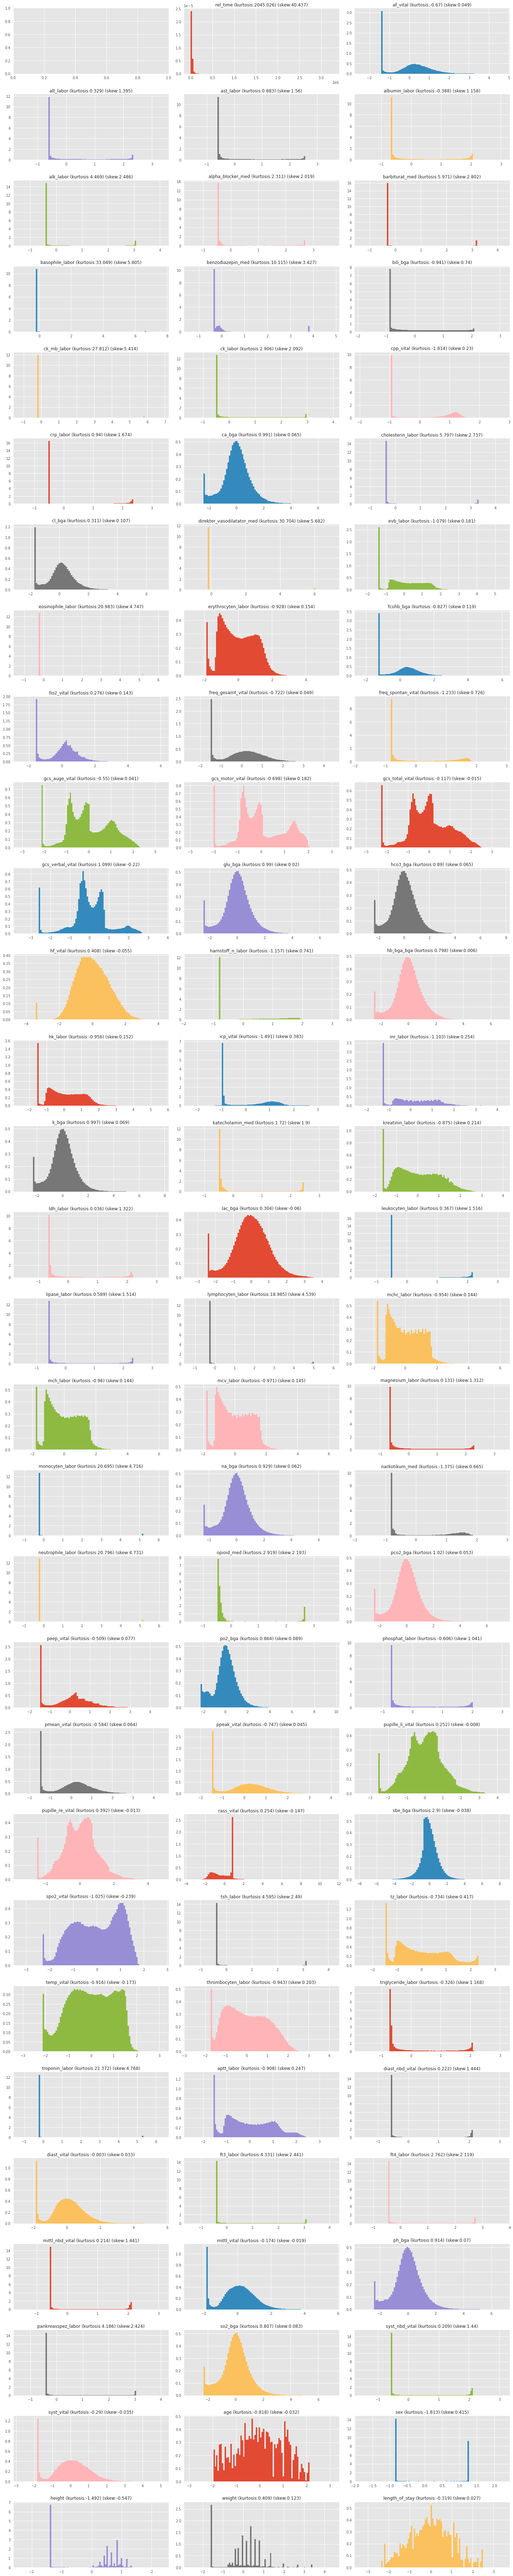

In [148]:
# Set the default color cycle
mpl.style.use("seaborn-notebook")
fig, axs = plt.subplots(30, 3)
fig.set_figheight(100)
fig.set_figwidth(20)

colors = plt.rcParams["axes.prop_cycle"]() 


for i, ax in enumerate(fig.axes):
        
        if i < len(dfft.columns) and dfft.columns[i] != "pat_id":
            
            # get column name
            column_name = dfft.columns[i]
            print("Creating column {}/{} - {:<50}".format(i, len(dfft.columns)-1, column_name), end="\r")
            
            # Extract data
            series = dfft[column_name].dropna()
            
            #Calculating Skew and Kurtosis 
            kurtosis = round((stats.kurtosis(series)), ndigits=3)
            skew = round((stats.skew(series)), ndigits=3)
            
            
            # Create subplot
            color = next(colors)["color"]
            bins = len(series.value_counts()) if len(series.value_counts()) <= 100 else 100
            ax.hist(series, density=True, bins=bins, color=color, range=(series.min()-1, series.max()+1))
            ax.set_title(column_name+" (kurtosis:{}) (skew:{})".format(kurtosis,skew))
            ax.ticklabel_format(axis="y", useOffset=False)
            
fig.tight_layout()        
fig.show()

## Testing & Debugging Area

In [ ]:
# Load the datasets
path = "../master-thesis/data/uke_clean.parquet"
test = pd.read_parquet(path)
test = test.iloc[:,20::5]
test.head()

In [ ]:
def fill(df):
    ''' Replace nan with median of that column '''
    
    df_t = df.interpolate(method='linear')
    
    return df_t

In [ ]:
df_t = fill(test)

In [ ]:
df_t.head(3)

In [ ]:
df_t.isna().head(3)

In [ ]:
series = "freq_gesamt_vital"
sns.lineplot(data = df_t.iloc[:200,:], x=df_t.iloc[:200,:].index, y=series)
sns.lineplot(data = test.iloc[:200,:], x=test.iloc[:200,:].index, y=series, marker = "o")